In [107]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

In [108]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
caffe_root = '../../caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

In [109]:
import os
if os.path.isfile('./models/snapshots/itracker_iter_92000.caffemodel'):
    print ('Caffemodel found.')
else:
    print ('Caffemodel not found')

Caffemodel found.


In [110]:
caffe.set_mode_cpu()

model_def = './models/itracker_deploy.prototxt'
model_weights = './models/snapshots/itracker_iter_92000.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

In [111]:
# for reading .mat files
import scipy.io


In [112]:

# load the mean images
mu_face = scipy.io.loadmat('./models/mean_images/mean_face_224.mat')
mu_right = scipy.io.loadmat('./models/mean_images/mean_right_224.mat')
mu_left = scipy.io.loadmat('./models/mean_images/mean_left_224.mat')

# average over pixels to obtain the mean (RGB) pixel values
mu_face = mu_face['image_mean'].mean(0).mean(0)
mu_right = mu_right['image_mean'].mean(0).mean(0)  
mu_left = mu_left['image_mean'].mean(0).mean(0)  
print(mu_face.shape)

(3,)


In [113]:
# create transformers for the input data
transformer_image_face = caffe.io.Transformer({'image_face': net.blobs['image_face'].data.shape})
transformer_image_right = caffe.io.Transformer({'image_right': net.blobs['image_right'].data.shape})
transformer_image_left = caffe.io.Transformer({'image_left': net.blobs['image_left'].data.shape})
transformer_facegrid = caffe.io.Transformer({'facegrid': net.blobs['facegrid'].data.shape})



In [114]:
# move image channels to outermost dimension
transformer_image_face.set_transpose('image_face', (2,0,1))
transformer_image_right.set_transpose('image_right', (2,0,1))
transformer_image_left.set_transpose('image_left', (2,0,1))

In [115]:
# subtract the dataset-mean value in each channel
transformer_image_face.set_mean('image_face', mu_face) 
transformer_image_right.set_mean('image_right', mu_right)
transformer_image_left.set_mean('image_left', mu_left)

In [116]:
# set the size of the input 
net.blobs['image_face'].reshape(256,        # batch size
                          3,         # 3-channel (RBG) images
                          224, 224)  # image size is 224x224
net.blobs['image_right'].reshape(256,        # batch size
                          3,         # 3-channel (RBG) images
                          224, 224)  # image size is 224x224
net.blobs['image_left'].reshape(256,        # batch size
                          3,         # 3-channel (RBG) images
                          224, 224)  # image size is 224x224
net.blobs['facegrid'].reshape(256,        # batch size
                          625,         
                          1, 1)  

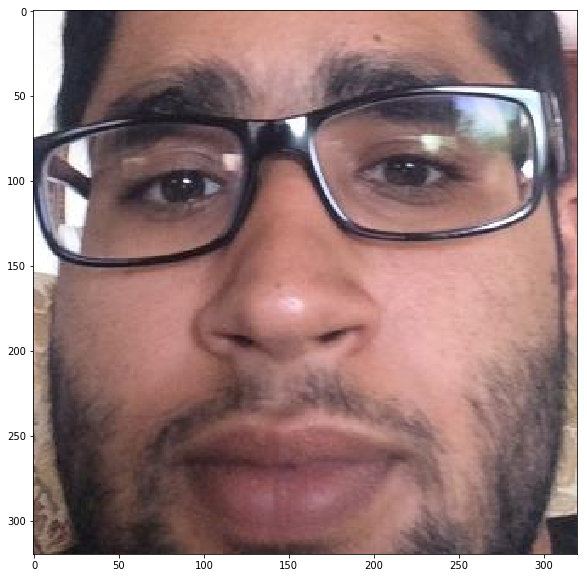

In [117]:
# load image_face
face = caffe.io.load_image('appleFace00003/00000.jpg')
transformed_image_face = transformer_image_face.preprocess('image_face', face)
plt.imshow(face)

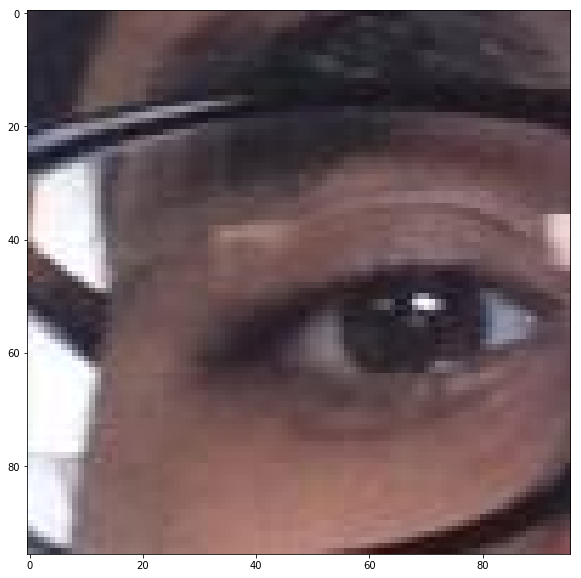

In [118]:
# load image right eye
right_eye = caffe.io.load_image('appleRightEye00003/00000.jpg')
transformed_image_right = transformer_image_right.preprocess('image_right', right_eye)
plt.imshow(right_eye)

(3, 224, 224)


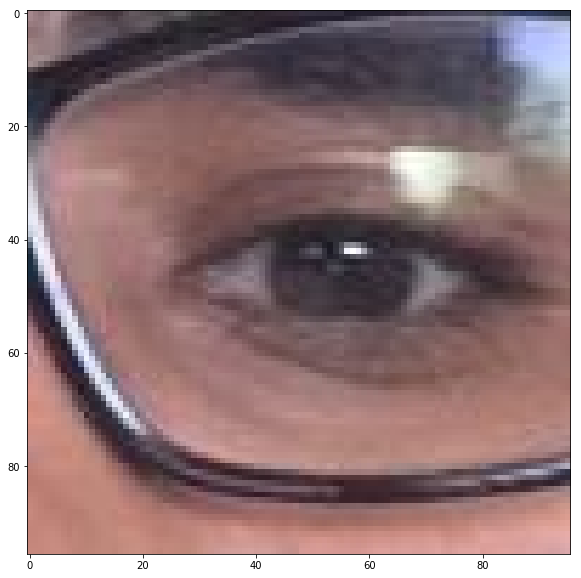

In [119]:
# load image left eye
left_eye = caffe.io.load_image('appleLeftEye00003/00000.jpg')
transformed_image_left = transformer_image_left.preprocess('image_left', left_eye)
plt.imshow(left_eye)
print(transformed_image_left.shape)

In [121]:
# load facegrid
facegrid = scipy.io.loadmat('facegrid00003.mat')['labelFaceGrid'].T
print(facegrid.shape)

(625, 1)


In [122]:
# copy the image data into the memory allocated for the net
net.blobs['image_face'].data[...] = transformed_image_face
net.blobs['image_right'].data[...] = transformed_image_right
net.blobs['image_left'].data[...] = transformed_image_left
net.blobs['facegrid'].data[...] = np.reshape(facegrid, (625,1,1))

In [123]:
### perform classification
output = net.forward()


In [124]:
print(output['fc3'][0])

[-0.01329699 -6.418091  ]
